In [191]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import re
import argparse
import csv
import json
import pprint
import subprocess
import dcor 

# AZURE API

In [2]:
from openai import AzureOpenAI
# gets the API Key from environment variable AZURE_OPENAI_API_KEY
client = AzureOpenAI(
    azure_endpoint="https://team5-chatgpt-4-api.openai.azure.com/",
    api_version = "2023-05-15",  # Use the latest available version
    api_key = "9423fcf02a494b5cbe440c6971903ba7",
)

In [3]:
#read the dataset from the jsonl file
df = pd.read_json('DATASETS\human-eval-modified.jsonl', lines=True)

df.head()




,task_id,prompt,entry_point,canonical_solution,test
0,HumanEval/0,from typing import List\n\n\ndef has_close_ele...,has_close_elements,"for idx, elem in enumerate(numbers):\n ...","\n\nMETADATA = {\n 'author': 'jt',\n 'da..."
1,HumanEval/1,from typing import List\n\n\ndef separate_pare...,separate_paren_groups,result = []\n current_string = []\n ...,"\n\nMETADATA = {\n 'author': 'jt',\n 'da..."
2,HumanEval/2,\n\ndef truncate_number(number: float) -> floa...,truncate_number,return number % 1.0\n,"\n\nMETADATA = {\n 'author': 'jt',\n 'da..."
3,HumanEval/3,from typing import List\n\n\ndef below_zero(op...,below_zero,balance = 0\n\n for op in operations:\n...,"\n\nMETADATA = {\n 'author': 'jt',\n 'da..."
4,HumanEval/4,from typing import List\n\n\ndef mean_absolute...,mean_absolute_deviation,mean = sum(numbers) / len(numbers)\n re...,"\n\nMETADATA = {\n 'author': 'jt',\n 'da..."


# Generating the test cases as function calls with test inputs

In [58]:
# chat completion
responses = pd.DataFrame(columns=['taskID','prompt', 'entry_point', 'response'])

taskID = df['task_id'].tolist()
prompts = df['prompt'].tolist()
entry_points = df['entry_point'].tolist()

l = len(df)

tests= 10

for i in range(l):
    ID = taskID[i]
    problem_statement = prompts[i]
    entry_point = entry_points[i]
        
    response = client.chat.completions.create(
        model="gpt4-api",  # The name you used when deploying the model
        messages=[
            {"role": "system", "content": "You are a helpful Python programming assistant. Your objective is to create test inputs for the given problem."},
            {"role": "user", "content": f"""For the given problem statement, create test inputs. The format of the input is a list of inputs.
                                        The problem statement is: {problem_statement}.
                                        The entry point is: {entry_point},
                                        The input list is {tests} inputs representing {tests} test cases. Cover basic test cases and edge cases.
                                        Return only the function calls with each of the test cases, each in a separate line, without any other text."""},
        ]
    )

    #save the response to a variable
    response_text = response.choices[0].message.content
    #create a temp dataframe to store the responses
    temp_df = pd.DataFrame([[ID, problem_statement, entry_point, response_text]], columns=['taskID','prompt', 'entry_point', 'response'])
    #concatenate the temp dataframe to the responses dataframe
    responses = pd.concat([responses, temp_df], ignore_index=True)
    

# Parsing the test cases as function calls

In [64]:
def remove_outside_quotes(text):
    # Match quotes outside of parentheses and replace them
    result = re.sub(r'\"(?![^()]*\))', '', text)
    result = re.sub(r"\'(?![^()]*\))", '', result)
    return result


tests = 10


# create a dataframe to store the inputs and to change dynamically (the columns) based on the number of tests
cols = ['task_id'] + [f'test_{i}' for i in range(1, tests+1)]


All = pd.DataFrame(columns=cols)


for row in responses.iterrows():
    #parse the response to get the list of inputs
    inputs = row[1]['response'].split("\n")
    #remove any input that doesn't have the entry point
    inputs = [input for input in inputs if row[1]['entry_point'] in input]

    #remove the quotes from the inputs using the function defined above
    inputs = [remove_outside_quotes(input) for input in inputs]

    #remove any leading or trailing whitespaces
    inputs = [input.strip() for input in inputs]
    #remove commas if they are the last character
    inputs = [input[:-1] if input[-1] == ',' else input for input in inputs]

    # print("\n")
    # print(50*"-")


    id = row[1]['taskID']
    
    # create a temp dataframe to store the inputs
    temp_df = pd.DataFrame([[id, inputs[0], inputs[1], inputs[2], inputs[3], inputs[4], inputs[5], inputs[6], inputs[7], inputs[8], inputs[9]]], 
                           columns=cols)

    #concatenate the temp dataframe to the All dataframe
    All = pd.concat([All, temp_df], ignore_index=True)


In [65]:
All

,task_id,test_1,test_2,test_3,test_4,test_5,test_6,test_7,test_8,test_9,test_10
0,HumanEval/0,"has_close_elements([], 1.0)","has_close_elements([1.0], 0.5)","has_close_elements([1.0, 2.0, 3.0], 1.5)","has_close_elements([1.0, 3.0, 2.1], 0.2)","has_close_elements([0.1, 0.15, 0.3], 0.05)","has_close_elements([10.0, 20.0, 20.1], 0.15)","has_close_elements([1.5, 2.0, 3.0, 1.55], 0.06)","has_close_elements([-1.0, -2.0, -1.99], 0.01)","has_close_elements([1.23456, 1.23458, 2.34567]...","has_close_elements([5.5, 5.7, 5.9], 0.22)"
1,HumanEval/1,separate_paren_groups(((()))'),separate_paren_groups(() (()) ((()))'),separate_paren_groups((( )( ))'),separate_paren_groups((( )( )) (( ))'),separate_paren_groups((( ( )(( )) ))'),separate_paren_groups(( )( )'),separate_paren_groups(''),separate_paren_groups((((())))'),separate_paren_groups(()()()'),separate_paren_groups((())()((()))')
2,HumanEval/2,truncate_number(0.75),truncate_number(10.01),truncate_number(5.0),truncate_number(1.9999),truncate_number(999.999),truncate_number(0.0001),truncate_number(123.123),truncate_number(0.5),truncate_number(100.89),truncate_number(6000.000001)
3,HumanEval/3,"below_zero([100, -50, -30])",below_zero([-1]),"below_zero([1, -2, 3, -4, 5, -10])","below_zero([0, 0, 0, 0])","below_zero([-100, 50, 60])","below_zero([5, 15, -20, 5, -6])","below_zero([15, -10, -7, 2])","below_zero([1, 2, 3, -6])","below_zero([10, -1, -1, -1, -1, -1, -1, -1, -1...","below_zero([7, 14, -30, 9])"
4,HumanEval/4,"mean_absolute_deviation([1.0, 2.0, 3.0, 4.0, 5...","mean_absolute_deviation([1.1, 1.1, 1.1, 1.1])","mean_absolute_deviation([-5.0, 0.0, 5.0, 10.0])",mean_absolute_deviation([100]),mean_absolute_deviation([]),"mean_absolute_deviation([10.5, 10.5, 10.5, 10.5])","mean_absolute_deviation([-2.5, -1.0, 0.0, 1.0,...",mean_absolute_deviation([0.33]),"mean_absolute_deviation([0.0001, 100000])","mean_absolute_deviation([2.5, -3.2, 4.8, -2.5,..."
...,...,...,...,...,...,...,...,...,...,...,...
159,HumanEval/159,"eat(0, 0, 0)","eat(5, 0, 20)","eat(0, 10, 5)","eat(1000, 1000, 1000)","eat(500, 300, 200)","eat(250, 750, 500)","eat(5, 500, 5)","eat(900, 80, 0)","eat(600, 700, 800)","eat(0, 0, 1000)"
160,HumanEval/160,"do_algebra(['+'], [2, 3])","do_algebra(['-', '+', '*'], [10, 5, 2, 3])","do_algebra(['*', '+', '//'], [1, 2, 3, 4])","do_algebra(['**', '-'], [2, 3, 4])","do_algebra(['+', '*', '-', '//', '**'], [2, 3,...","do_algebra(['//', '*', '+'], [100, 10, 5, 7])","do_algebra(['-'], [10, 4])","do_algebra(['**', '//', '+', '*'], [3, 2, 4, 5...","do_algebra(['*'], [7, 3])","do_algebra(['+', '-', '*', '**', '//'], [1, 4,..."
161,HumanEval/161,"solve(""1234"")","solve(""ab"")","solve(""#a@C"")","solve(""abcdEFGHIJ"")","solve("""")","solve(""1111"")","solve(""123abcDEF"")","solve(""@#$%^"")","solve(""argUING1234"")","solve(""spaces are cool"")"
162,HumanEval/162,string_to_md5('Hello world'),string_to_md5(''),string_to_md5('password123'),string_to_md5('123'),string_to_md5('string_to_md5'),string_to_md5('Example with spaces'),string_to_md5('special@#chars&*!$'),string_to_md5('<html><body>This is a test</bod...,string_to_md5('a'),string_to_md5('Non-English text like: текст')


In [66]:
#merge all with df to get the final dataframe
final_df = pd.merge(df, All, on = 'task_id', how='left')
final_df

,task_id,prompt,entry_point,canonical_solution,test,test_1,test_2,test_3,test_4,test_5,test_6,test_7,test_8,test_9,test_10
0,HumanEval/0,from typing import List\n\n\ndef has_close_ele...,has_close_elements,"for idx, elem in enumerate(numbers):\n ...","\n\nMETADATA = {\n 'author': 'jt',\n 'da...","has_close_elements([], 1.0)","has_close_elements([1.0], 0.5)","has_close_elements([1.0, 2.0, 3.0], 1.5)","has_close_elements([1.0, 3.0, 2.1], 0.2)","has_close_elements([0.1, 0.15, 0.3], 0.05)","has_close_elements([10.0, 20.0, 20.1], 0.15)","has_close_elements([1.5, 2.0, 3.0, 1.55], 0.06)","has_close_elements([-1.0, -2.0, -1.99], 0.01)","has_close_elements([1.23456, 1.23458, 2.34567]...","has_close_elements([5.5, 5.7, 5.9], 0.22)"
1,HumanEval/1,from typing import List\n\n\ndef separate_pare...,separate_paren_groups,result = []\n current_string = []\n ...,"\n\nMETADATA = {\n 'author': 'jt',\n 'da...",separate_paren_groups(((()))'),separate_paren_groups(() (()) ((()))'),separate_paren_groups((( )( ))'),separate_paren_groups((( )( )) (( ))'),separate_paren_groups((( ( )(( )) ))'),separate_paren_groups(( )( )'),separate_paren_groups(''),separate_paren_groups((((())))'),separate_paren_groups(()()()'),separate_paren_groups((())()((()))')
2,HumanEval/2,\n\ndef truncate_number(number: float) -> floa...,truncate_number,return number % 1.0\n,"\n\nMETADATA = {\n 'author': 'jt',\n 'da...",truncate_number(0.75),truncate_number(10.01),truncate_number(5.0),truncate_number(1.9999),truncate_number(999.999),truncate_number(0.0001),truncate_number(123.123),truncate_number(0.5),truncate_number(100.89),truncate_number(6000.000001)
3,HumanEval/3,from typing import List\n\n\ndef below_zero(op...,below_zero,balance = 0\n\n for op in operations:\n...,"\n\nMETADATA = {\n 'author': 'jt',\n 'da...","below_zero([100, -50, -30])",below_zero([-1]),"below_zero([1, -2, 3, -4, 5, -10])","below_zero([0, 0, 0, 0])","below_zero([-100, 50, 60])","below_zero([5, 15, -20, 5, -6])","below_zero([15, -10, -7, 2])","below_zero([1, 2, 3, -6])","below_zero([10, -1, -1, -1, -1, -1, -1, -1, -1...","below_zero([7, 14, -30, 9])"
4,HumanEval/4,from typing import List\n\n\ndef mean_absolute...,mean_absolute_deviation,mean = sum(numbers) / len(numbers)\n re...,"\n\nMETADATA = {\n 'author': 'jt',\n 'da...","mean_absolute_deviation([1.0, 2.0, 3.0, 4.0, 5...","mean_absolute_deviation([1.1, 1.1, 1.1, 1.1])","mean_absolute_deviation([-5.0, 0.0, 5.0, 10.0])",mean_absolute_deviation([100]),mean_absolute_deviation([]),"mean_absolute_deviation([10.5, 10.5, 10.5, 10.5])","mean_absolute_deviation([-2.5, -1.0, 0.0, 1.0,...",mean_absolute_deviation([0.33]),"mean_absolute_deviation([0.0001, 100000])","mean_absolute_deviation([2.5, -3.2, 4.8, -2.5,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159,HumanEval/159,"\ndef eat(number, need, remaining):\n """"""\n...",eat,if(need <= remaining):\n return [ n...,def check(candidate):\n total_tests_xyz = 6...,"eat(0, 0, 0)","eat(5, 0, 20)","eat(0, 10, 5)","eat(1000, 1000, 1000)","eat(500, 300, 200)","eat(250, 750, 500)","eat(5, 500, 5)","eat(900, 80, 0)","eat(600, 700, 800)","eat(0, 0, 1000)"
160,HumanEval/160,"\ndef do_algebra(operator, operand):\n """"""\...",do_algebra,expression = str(operand[0])\n for oprt...,def check(candidate):\n total_tests_xyz = 3...,"do_algebra(['+'], [2, 3])","do_algebra(['-', '+', '*'], [10, 5, 2, 3])","do_algebra(['*', '+', '//'], [1, 2, 3, 4])","do_algebra(['**', '-'], [2, 3, 4])","do_algebra(['+', '*', '-', '//', '**'], [2, 3,...","do_algebra(['//', '*', '+'], [100, 10, 5, 7])","do_algebra(['-'], [10, 4])","do_algebra(['**', '//', '+', '*'], [3, 2, 4, 5...","do_algebra(['*'], [7, 3])","do_algebra(['+', '-', '*', '**', '//'], [1, 4,..."
161,HumanEval/161,"\ndef solve(s):\n """"""You are given a string...",solve,flg = 0\n idx = 0\n new_str = list(s...,def check(candidate):\n total_tests_xyz = 8...,"solve(""1234"")","solve(""ab"")","solve(""#a@C"")","solve(""abcdEFGHIJ"")","solve("""")","solve(""1111"")","solv

In [67]:
final_df.to_csv('DATASETs\human-eval-modified-with-tests.csv', index=False)

#export the final dataframe to a jsonl file
final_df.to_json('DATASETS\human-eval-modified-with-tests.jsonl', orient='records', lines=True)

# executing the test cases

In [210]:
df = pd.read_json('DATASETS\human-eval-modified-with-tests.jsonl', lines=True)
codes = pd.read_csv("RESULTS\\trial 3\dataset_HumanEval_model_gpt-3.5-turbo_n_5_tempr_1_temps_1_trial_3.csv")

df_with_codes = pd.merge(df, codes, on = 'task_id', how='inner')

#drop columns that are not needed
df_with_codes = df_with_codes.drop(columns=['prompt_y', 'canonical_solution', 'test', 'entry_point'])
#rename the columns
df_with_codes = df_with_codes.rename(columns={"prompt_x": "prompt"})

#get the average pass_rate for each task_id
df_with_codes['average_pass_rate'] = df_with_codes[['pass_rate_1', 'pass_rate_2', 'pass_rate_3', 'pass_rate_4', 'pass_rate_5']].mean(axis=1)

#drop the pass_rate columns
df_with_codes = df_with_codes.drop(columns=['pass_rate_0','pass_rate_1', 'pass_rate_2', 'pass_rate_3', 'pass_rate_4', 'pass_rate_5'])

#drop the error_rate columns
df_with_codes = df_with_codes.drop(columns=['err_0', 'err_1', 'err_2', 'err_3', 'err_4', 'err_5'])

#add 10 columns to the dataframe to store the results of the tests
cols = [f'test_{i}_results' for i in range(1, 11)]
df_with_codes[cols] = pd.DataFrame([['' for i in range(10)]], index=df_with_codes.index)

df_with_codes.head()


,task_id,prompt,test_1,test_2,test_3,test_4,test_5,test_6,test_7,test_8,...,test_1_results,test_2_results,test_3_results,test_4_results,test_5_results,test_6_results,test_7_results,test_8_results,test_9_results,test_10_results
0,HumanEval/0,from typing import List\n\n\ndef has_close_ele...,"has_close_elements([], 1.0)","has_close_elements([1.0], 0.5)","has_close_elements([1.0, 2.0, 3.0], 1.5)","has_close_elements([1.0, 3.0, 2.1], 0.2)","has_close_elements([0.1, 0.15, 0.3], 0.05)","has_close_elements([10.0, 20.0, 20.1], 0.15)","has_close_elements([1.5, 2.0, 3.0, 1.55], 0.06)","has_close_elements([-1.0, -2.0, -1.99], 0.01)",...,,,,,,,,,,
1,HumanEval/1,from typing import List\n\n\ndef separate_pare...,separate_paren_groups(((()))'),separate_paren_groups(() (()) ((()))'),separate_paren_groups((( )( ))'),separate_paren_groups((( )( )) (( ))'),separate_paren_groups((( ( )(( )) ))'),separate_paren_groups(( )( )'),separate_paren_groups(''),separate_paren_groups((((())))'),...,,,,,,,,,,
2,HumanEval/2,\n\ndef truncate_number(number: float) -> floa...,truncate_number(0.75),truncate_number(10.01),truncate_number(5.0),truncate_number(1.9999),truncate_number(999.999),truncate_number(0.0001),truncate_number(123.123),truncate_number(0.5),...,,,,,,,,,,
3,HumanEval/3,from typing import List\n\n\ndef below_zero(op...,"below_zero([100, -50, -30])",below_zero([-1]),"below_zero([1, -2, 3, -4, 5, -10])","below_zero([0, 0, 0, 0])","below_zero([-100, 50, 60])","below_zero([5, 15, -20, 5, -6])","below_zero([15, -10, -7, 2])","below_zero([1, 2, 3, -6])",...,,,,,,,,,,
4,HumanEval/4,from typing import List\n\n\ndef mean_absolute...,"mean_absolute_deviation([1.0, 2.0, 3.0, 4.0, 5...","mean_absolute_deviation([1.1, 1.1, 1.1, 1.1])","mean_absolute_deviation([-5.0, 0.0, 5.0, 10.0])",mean_absolute_deviation([100]),mean_absolute_deviation([]),"mean_absolute_deviation([10.5, 10.5, 10.5, 10.5])","mean_absolute_deviation([-2.5, -1.0, 0.0, 1.0,...",mean_absolute_deviation([0.33]),...,,,,,,,,,,


In [211]:
def run_tests(check_program, test_number , code_number, task_id=None, timeout=40):
    try:
        result = subprocess.run(['python', '-c', check_program], stdout=subprocess.PIPE,
                                        stderr=subprocess.PIPE, timeout=timeout)
        

    except Exception as e:
        
        with open('RESULTS\error_log.txt', 'a') as f:
            f.write(f"Task ID: {task_id}\n")
            f.write(f"Code number: {code_number}\n")
            f.write(f"Test Number: {test_number}\n")
            f.write("Error:")
            f.write(str(e))
            f.write("\n")
            f.write( 50*"-")
            f.write("\n")
        return "Error"
     
    return result.stdout.decode('utf-8').strip()


In [212]:
#loop over each row in the dataset
for row in df_with_codes.iterrows():
    id = row[1]['task_id']
    # loop over the tests to get the test inputs
    for j in range(1,11):
        
        test = row[1][f'test_{j}']

        test_results = []
        
        #loop over the codes in the dataset
        for i in range(0,6):
            code = row[1][f'code_{i}']
            test_prepared = f"print({test})"
            check_program = f"{code}\n{test_prepared}"
            res = run_tests(check_program, test_number = j, code_number = i ,task_id = id, timeout=40 )
            test_results.append(res)

        #update the dataframe with the test results
        df_with_codes.at[row[0], f'test_{j}_results'] = test_results
    

In [213]:
df_with_codes

,task_id,prompt,test_1,test_2,test_3,test_4,test_5,test_6,test_7,test_8,...,test_1_results,test_2_results,test_3_results,test_4_results,test_5_results,test_6_results,test_7_results,test_8_results,test_9_results,test_10_results
0,HumanEval/0,from typing import List\n\n\ndef has_close_ele...,"has_close_elements([], 1.0)","has_close_elements([1.0], 0.5)","has_close_elements([1.0, 2.0, 3.0], 1.5)","has_close_elements([1.0, 3.0, 2.1], 0.2)","has_close_elements([0.1, 0.15, 0.3], 0.05)","has_close_elements([10.0, 20.0, 20.1], 0.15)","has_close_elements([1.5, 2.0, 3.0, 1.55], 0.06)","has_close_elements([-1.0, -2.0, -1.99], 0.01)",...,"[False, False, False, False, False, False]","[False, False, False, False, False, False]","[True, True, True, True, True, True]","[False, False, False, False, False, False]","[True, True, True, True, True, True]","[True, True, True, True, True, True]","[True, True, True, True, True, True]","[False, False, False, False, False, False]","[True, True, True, True, True, True]","[True, True, True, True, True, True]"
1,HumanEval/1,from typing import List\n\n\ndef separate_pare...,separate_paren_groups(((()))'),separate_paren_groups(() (()) ((()))'),separate_paren_groups((( )( ))'),separate_paren_groups((( )( )) (( ))'),separate_paren_groups((( ( )(( )) ))'),separate_paren_groups(( )( )'),separate_paren_groups(''),separate_paren_groups((((())))'),...,"[, , , , , ]","[, , , , , ]","[, , , , , ]","[, , , , , ]","[, , , , , ]","[, , , , , ]","[[], [], [], [], [], None]","[, , , , , ]","[, , , , , ]","[, , , , , ]"
2,HumanEval/2,\n\ndef truncate_number(number: float) -> floa...,truncate_number(0.75),truncate_number(10.01),truncate_number(5.0),truncate_number(1.9999),truncate_number(999.999),truncate_number(0.0001),truncate_number(123.123),truncate_number(0.5),...,"[0.75, 0.75, 0.75, 0.75, 0.75, 0.75]","[0.009999999999999787, 0.009999999999999787, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999]","[0.9990000000000236, 0.9990000000000236, 0.999...","[0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001]","[0.12300000000000466, 0.12300000000000466, 0.1...","[0.5, 0.5, 0.5, 0.5, 0.5, 0.5]","[0.8900000000000006, 0.8900000000000006, 0.890...","[1.0000003385357559e-06, 1.0000003385357559e-0..."
3,HumanEval/3,from typing import List\n\n\ndef below_zero(op...,"below_zero([100, -50, -30])",below_zero([-1]),"below_zero([1, -2, 3, -4, 5, -10])","below_zero([0, 0, 0, 0])","below_zero([-100, 50, 60])","below_zero([5, 15, -20, 5, -6])","below_zero([15, -10, -7, 2])","below_zero([1, 2, 3, -6])",...,"[False, False, False, False, False, False]","[True, True, True, True, True, True]","[True, True, True, True, True, True]","[False, False, False, False, False, False]","[True, True, True, True, True, True]","[True, True, True, True, True, True]","[True, True, True, True, True, True]","[False, False, False, False, False, False]","[False, False, False, False, False, False]","[True, True, True, True, True, True]"
4,HumanEval/4,from typing import List\n\n\ndef mean_absolute...,"mean_absolute_deviation([1.0, 2.0, 3.0, 4.0, 5...","mean_absolute_deviation([1.1, 1.1, 1.1, 1.1])","mean_absolute_deviation([-5.0, 0.0, 5.0, 10.0])",mean_absolute_deviation([100]),mean_absolute_deviation([]),"mean_absolute_deviation([10.5, 10.5, 10.5, 10.5])","mean_absolute_deviation([-2.5, -1.0, 0.0, 1.0,...",mean_absolute_deviation([0.33]),...,"[1.2, 1.2, 1.2, 1.2, 1.2, 1.2]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[5.0, 5.0, 5.0, 5.0, 5.0, 5.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[, , , , , ]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.4, 1.4, 1.4, 1.4, 1.4, 1.4]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[49999.99995, 49999.99995, 49999.99995, 49999....","[3.5, 3.5, 3.5, 3.5, 3.5, 3.5]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159,HumanEval/159,"\ndef eat(number, need, remaining):\n """"""\n...","eat(0, 0, 0)","eat(5, 0, 20)","eat(0, 10, 5)","eat(1000, 1000, 1000)","eat(500, 300, 200)","eat(250, 750, 500)"

# Comparing the test results

In [214]:
# add columns to store the pass rates for each test
cols = [f'test_{i}_pass_rate' for i in range(1, 11)]
df_with_codes[cols] = pd.DataFrame([['' for i in range(10)]], index=df_with_codes.index)


df_with_codes.head()

,task_id,prompt,test_1,test_2,test_3,test_4,test_5,test_6,test_7,test_8,...,test_1_pass_rate,test_2_pass_rate,test_3_pass_rate,test_4_pass_rate,test_5_pass_rate,test_6_pass_rate,test_7_pass_rate,test_8_pass_rate,test_9_pass_rate,test_10_pass_rate
0,HumanEval/0,from typing import List\n\n\ndef has_close_ele...,"has_close_elements([], 1.0)","has_close_elements([1.0], 0.5)","has_close_elements([1.0, 2.0, 3.0], 1.5)","has_close_elements([1.0, 3.0, 2.1], 0.2)","has_close_elements([0.1, 0.15, 0.3], 0.05)","has_close_elements([10.0, 20.0, 20.1], 0.15)","has_close_elements([1.5, 2.0, 3.0, 1.55], 0.06)","has_close_elements([-1.0, -2.0, -1.99], 0.01)",...,,,,,,,,,,
1,HumanEval/1,from typing import List\n\n\ndef separate_pare...,separate_paren_groups(((()))'),separate_paren_groups(() (()) ((()))'),separate_paren_groups((( )( ))'),separate_paren_groups((( )( )) (( ))'),separate_paren_groups((( ( )(( )) ))'),separate_paren_groups(( )( )'),separate_paren_groups(''),separate_paren_groups((((())))'),...,,,,,,,,,,
2,HumanEval/2,\n\ndef truncate_number(number: float) -> floa...,truncate_number(0.75),truncate_number(10.01),truncate_number(5.0),truncate_number(1.9999),truncate_number(999.999),truncate_number(0.0001),truncate_number(123.123),truncate_number(0.5),...,,,,,,,,,,
3,HumanEval/3,from typing import List\n\n\ndef below_zero(op...,"below_zero([100, -50, -30])",below_zero([-1]),"below_zero([1, -2, 3, -4, 5, -10])","below_zero([0, 0, 0, 0])","below_zero([-100, 50, 60])","below_zero([5, 15, -20, 5, -6])","below_zero([15, -10, -7, 2])","below_zero([1, 2, 3, -6])",...,,,,,,,,,,
4,HumanEval/4,from typing import List\n\n\ndef mean_absolute...,"mean_absolute_deviation([1.0, 2.0, 3.0, 4.0, 5...","mean_absolute_deviation([1.1, 1.1, 1.1, 1.1])","mean_absolute_deviation([-5.0, 0.0, 5.0, 10.0])",mean_absolute_deviation([100]),mean_absolute_deviation([]),"mean_absolute_deviation([10.5, 10.5, 10.5, 10.5])","mean_absolute_deviation([-2.5, -1.0, 0.0, 1.0,...",mean_absolute_deviation([0.33]),...,,,,,,,,,,


In [215]:
df_with_codes.columns

Index(['task_id', 'prompt', 'test_1', 'test_2', 'test_3', 'test_4', 'test_5',
       'test_6', 'test_7', 'test_8', 'test_9', 'test_10', 'code_0', 'code_1',
       'code_2', 'code_3', 'code_4', 'code_5', 'average_pass_rate',
       'test_1_results', 'test_2_results', 'test_3_results', 'test_4_results',
       'test_5_results', 'test_6_results', 'test_7_results', 'test_8_results',
       'test_9_results', 'test_10_results', 'test_1_pass_rate',
       'test_2_pass_rate', 'test_3_pass_rate', 'test_4_pass_rate',
       'test_5_pass_rate', 'test_6_pass_rate', 'test_7_pass_rate',
       'test_8_pass_rate', 'test_9_pass_rate', 'test_10_pass_rate'],
      dtype='object')

In [216]:
#loop over each row in the dataset
for row in df_with_codes.iterrows():
    id = row[1]['task_id']
    # loop over the test results
    for j in range(1,11):
        
        results = row[1][f'test_{j}_results']

        ref_result = results[0]
        counter = 0
        #loop over the results of the tests
        for i, res in enumerate(results):
            if i == 0:
                continue
            #check if the result is correct
            if res == ref_result:
                counter += 1
        #calculate the pass rate
        pass_rate = float(counter / 5)

        #update the dataframe with the pass rate
        df_with_codes.at[row[0], f'test_{j}_pass_rate'] = pass_rate
                
            
#add a column to store the average pass rate for the tests
df_with_codes['average_tests_pass_rate'] = df_with_codes[['test_1_pass_rate', 'test_2_pass_rate', 'test_3_pass_rate', 'test_4_pass_rate', 'test_5_pass_rate', 'test_6_pass_rate', 'test_7_pass_rate', 'test_8_pass_rate', 'test_9_pass_rate', 'test_10_pass_rate']].mean(axis=1)
# make it as a percentage
df_with_codes['average_tests_pass_rate'] = df_with_codes['average_tests_pass_rate'] * 100
# make it float64
df_with_codes['average_tests_pass_rate'] = df_with_codes['average_tests_pass_rate'].astype('float64')


# getting the correlation and its graph

In [217]:
def visualize_corr(df, col1 ,col2):

    corrs = dcor.distance_correlation(df[col1], df[col2])
    print("The correlation between the average pass rate and", col2, "is", corrs)

    
    #plot the avg pass rate wih color red and sequence similarity with color blue
    plt.figure(figsize=(25,10))
    plt.scatter(df["task_id"],df[col2],color='blue')
    plt.scatter(df["task_id"],df[col1],color='red')
    plt.xlabel('Task ID')
    #rotate the x axis labels
    plt.xticks(ticks = [i for i in range(len(df))],labels = [i for i in range(len(df))], rotation=90)
    plt.ylabel('Scores')
    plt.legend([col2, col1])
    plt.title(f'{col2} vs {col1} ')
    plt.grid()
    plt.show()
    plt.savefig(f'RESULTS\\test cases results\{col2}_vs_{col1}.png')


The correlation between the average pass rate and average_tests_pass_rate is 0.7519342730389689


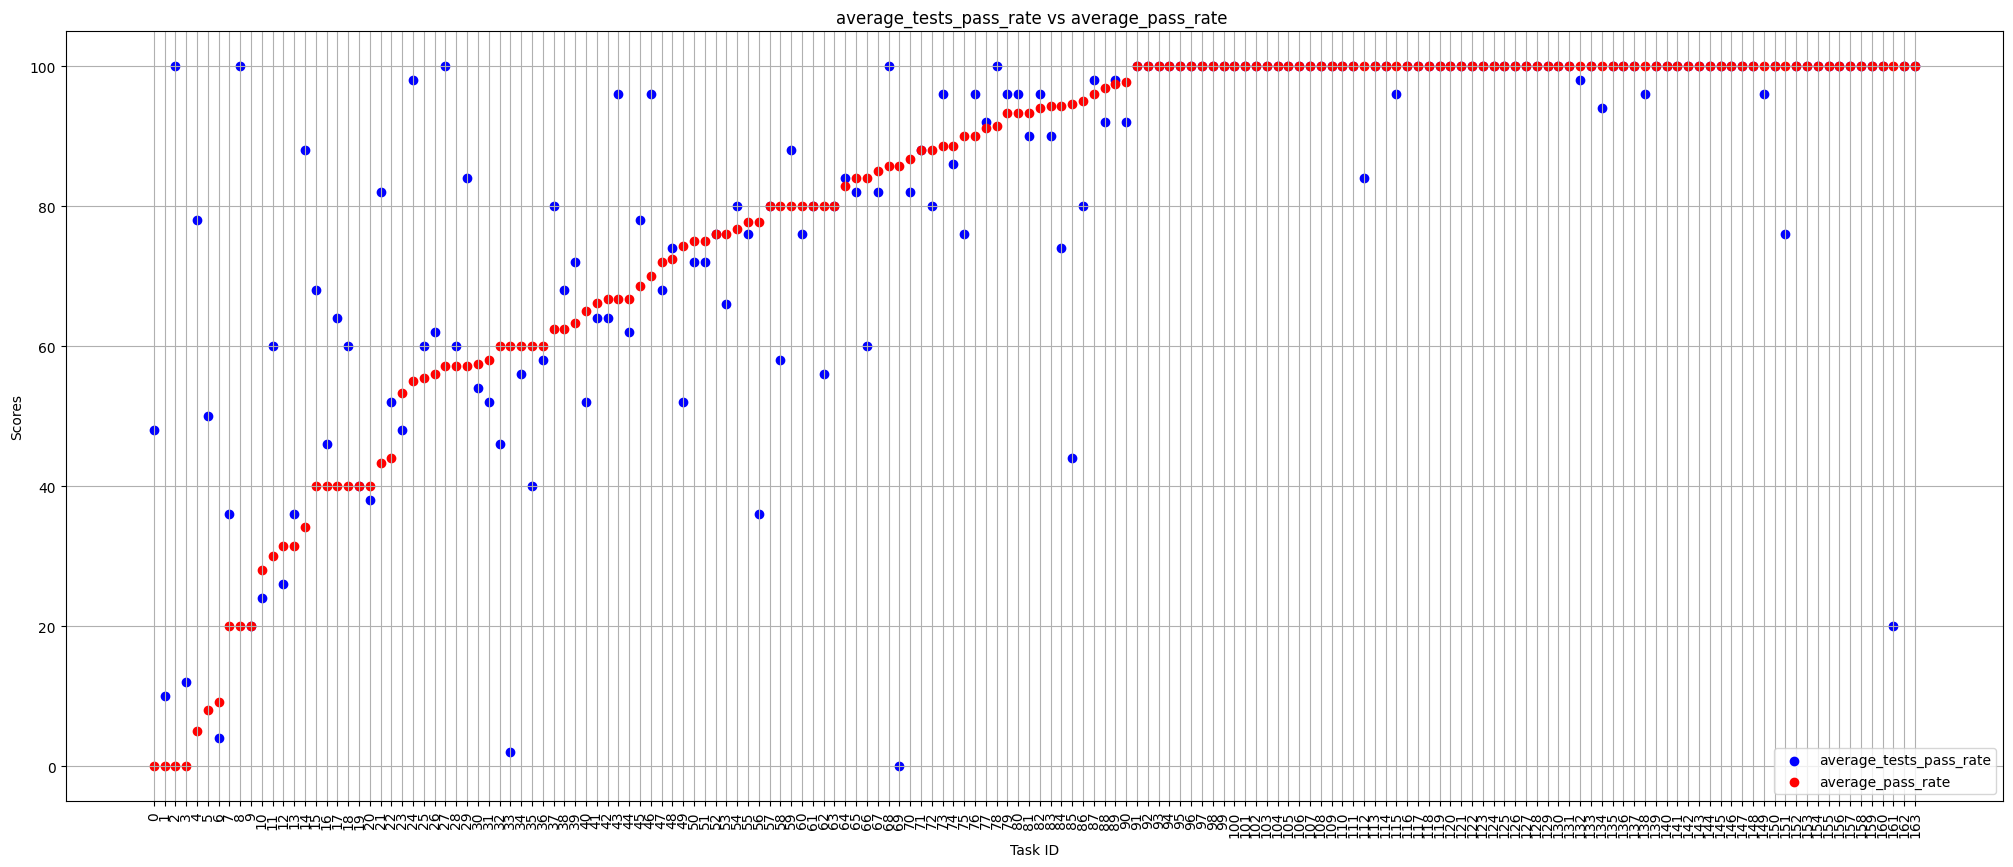

<Figure size 640x480 with 0 Axes>

In [218]:
visualize_corr(df_with_codes.sort_values(by = 'average_pass_rate'), 'average_pass_rate', 'average_tests_pass_rate')

In [219]:
df_with_codes.to_csv('RESULTS\\test cases results\\first results.csv', index=False)

In [220]:
#check for the 0's in the pass rates
j = 5
df_with_codes[df_with_codes[f'test_{j}_pass_rate'] == 0][f'test_{j}_results']

36                                     [, 2, 2, 3, 2, 2]
41                            [190, 45, 45, 45, 155, 45]
83     [9090909090902, Error, 1800000000000, 99000000...
113    [['the number of odd elements 0n the str0000ng...
148    [, ('Saturn', 'Jupiter', 'Mars', 'Earth', 'Ven...
159    [[1000, 0], [800, 0], [700, 0], [800, 0], [700...
Name: test_5_results, dtype: object